In [1]:
import numpy as np
from matplotlib import pyplot as plt
import george
from george import kernels
import emcee
import scipy.optimize as op


In [2]:
def get_gp(profile, t):
# Define the objective function (negative log-likelihood in this case).
    def nll(p):
        gp.set_parameter_vector(p)
        ll = gp.log_likelihood(y, quiet=True)
        return -ll if np.isfinite(ll) else 1e25

# And the gradient of the objective function.
    def grad_nll(p):
        gp.set_parameter_vector(p)
        return -gp.grad_log_likelihood(y, quiet=True)

    kernel = 100 * kernels.ExpSquaredKernel(metric=10**2)
    y = profile
    gp = george.GP(kernel, mean=np.mean(y), fit_mean=True,
               white_noise=np.log(1**2), fit_white_noise=True)
# You need to compute the GP once before starting the optimization.
    gp.compute(t)

# Print the initial ln-likelihood.
    print(gp.log_likelihood(y))

# Run the optimization routine.
    p0 = gp.get_parameter_vector()
    results = op.minimize(nll, p0, jac=grad_nll, method="L-BFGS-B")

# Update the kernel and print the final log-likelihood.
    gp.set_parameter_vector(results.x)
    return gp

In [3]:
def get_boundaries(profile, gp):
    mu, var = gp.predict(profile, np.arange(len(profile)), return_var=True)
    bins = len(profile)
    left = bins
    right = 0
    index = 0
    while left == bins:
        if mu[index] > 5.0 * noise:
            left = index
        index += 1
    index = 1
    while right == 0:
        if mu[-index] > 5.0 * noise:
            right = bins - index
        index += 1
    left = max(left-60,0)
    right = min(right+60, bins)
    return left, right

In [4]:
def count_components(data, threshold):
    databins = len(data)
    switch = 0
    components = 0
    for index in range(databins):        
        if (data[index] < -threshold and switch == 0):
            components += 1
            switch = 1
        if (switch == 1 and data[index] > threshold):
            switch = 0
    return components 

In [5]:
data = np.loadtxt('../../Data/nudot_tests/J0738-4042_residuals_1400.dat', comments='F')

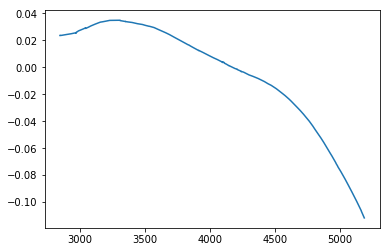

In [6]:
residuals = data[:,1]
dates = data[:,0]
plt.plot(dates,residuals)

In [7]:
gp1 = get_gp(residuals,dates)
print(gp1.log_likelihood(residuals), gp1.get_parameter_names(),gp1.get_parameter_vector())
noise = gp1.get_parameter_vector()[1]
print 'Noise=', noise


-305.85433416486836
(351.95867654600244, ('mean:value', 'white_noise:value', 'kernel:k1:log_constant', 'kernel:k2:metric:log_M_0_0'), array([ -0.01153641, -10.63658058,  -8.81971456,   7.81833749]))
Noise= -10.636580581224237


In [8]:
kernel_params = gp1.get_parameter_vector()
print(kernel_params)
kernel_params[3] = np.exp(kernel_params[3])
kernelprime = 100 * kernels.ExpSquaredDoublePrimeKernel(10.0)
kernelprime.set_parameter_vector(kernel_params[2:4])
print(kernelprime.get_parameter_vector())
gp1.set_parameter('mean:value',0.0)


[ -0.01153641 -10.63658058  -8.81971456   7.81833749]
[  -8.81971456 2485.76934683]


Noise= -10.636580581224237


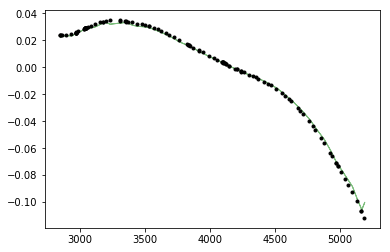

In [9]:
mu, var = gp1.predict(residuals, dates, return_var=True)
noise = gp1.get_parameter_vector()[1]
print 'Noise=', noise

plt.plot(dates, residuals, ".k")
plt.fill_between(dates, mu+var, mu-var, color="g", alpha=0.5)



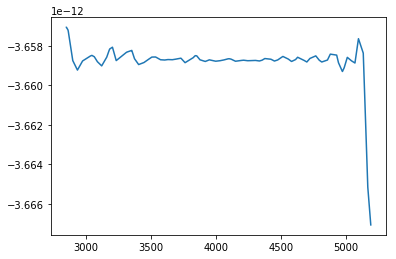

In [10]:
#1830-1059     2.46887171470          7  hlk+04     -3.658728E-13        5  hlk+04     
#0742-2822     5.9965594774           7  hlk+04     -6.04866E-13         5  hlk+04   
#1602-5100     1.15710291798          7  dmk+93     -9.3160E-14          5  dmk+93
f0 = 2.4688717147
period = 1.0/f0
f1 = -3.658728e-12
mu2, var2 = gp1.predict(residuals, dates, return_var=True, kernel = kernelprime )
mu2 = f1 - mu2/period/86400**2
fig,ax = plt.subplots()
ax.plot(dates[:],mu2[:])
ax.ticklabel_format(useOffset=False)
plt.show()

Running burn-in
Running production chain
Running burn-in
Running production chain


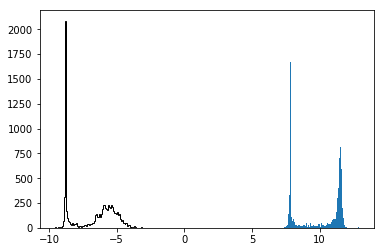

In [11]:
def lnprob(p):
# Trivial uniform prior.
    if np.any((-100 > p[1:]) + (p[1:] > 100)):
        return -np.inf

# Update the kernel and compute the lnlikelihood.
    gp1.set_parameter_vector(p)
    return gp1.lnlikelihood(residuals, quiet=True)

# Set up the sampler.
nwalkers, ndim = 36, len(gp1)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

# Initialize the walkers.
#p0 = gp1.get_parameter_vector() + 1e-4 * np.random.randn(nwalkers, ndim)
p0 = gp1.get_parameter_vector() + 1e-6 * np.random.randn(nwalkers, ndim)

print("Running burn-in")
p0, _, _ = sampler.run_mcmc(p0, 50)

print("Running production chain")
sampler.run_mcmc(p0, 200);
n, hb, dummy = plt.hist(sampler.flatchain[:,2],100, color="k", histtype="step")
p0[:,2] = hb[np.argmax(n)]+ 1e-6 * np.random.randn(nwalkers)
n, hb, dummy = plt.hist(sampler.flatchain[:,3],100)
p0[:,3] = hb[np.argmax(n)]+ 1e-6 * np.random.randn(nwalkers)
print("Running burn-in")
p0, _, _ = sampler.run_mcmc(p0, 50)

print("Running production chain")
sampler.run_mcmc(p0, 1000);
cornerplotdata = sampler.chain.reshape((-1,ndim))


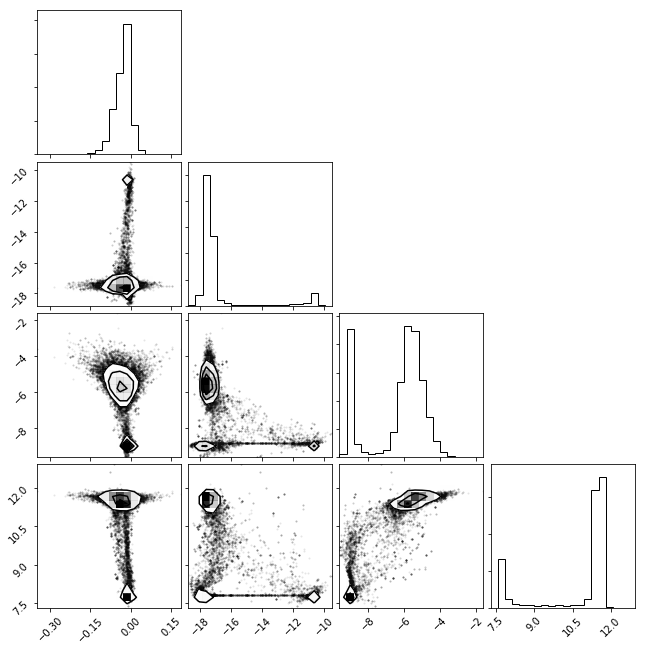

In [12]:
import corner
fig = corner.corner(cornerplotdata)


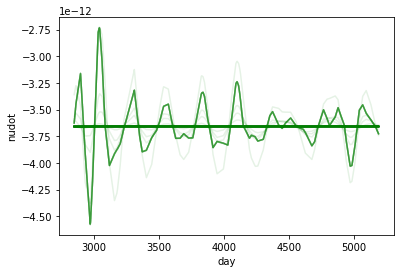

In [13]:
big_array = np.zeros((100,len(dates)))
np.seterr(all='ignore')
for i in range(100):
    # Choose a random walker and step.
    w = np.random.randint(sampler.chain.shape[0])
    n = np.random.randint(sampler.chain.shape[1])
    newvector=sampler.chain[w,n][2:4]
    newvector[1] = np.exp(newvector[1])
    kernelprime.set_parameter_vector(newvector)
    gp1.set_parameter('mean:value',0.0)
    mumc, dummy = gp1.predict(residuals, dates, kernel = kernelprime )
    big_array[i] = f1 - mumc/period/86400.**2
    plt.plot(dates,big_array[i], "g", alpha=0.1)
    #plt.ylim((-1.4e-14,-0.6e-14))
plt.xlabel('day')
plt.ylabel('nudot')
plt.savefig('probabilityNuDot.png')

In [14]:
means = np.mean(big_array,0)
sigmas = np.std(big_array,0)
snrs = np.divide(means,sigmas)

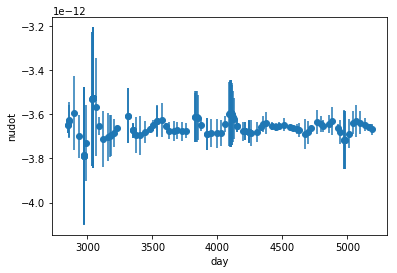

In [15]:
#plt.plot(dates,means)
plt.errorbar(dates,means,yerr=sigmas, fmt='o')
#plt.ylim((-1.5e-14,-0.5e-14))
plt.xlabel('day')
plt.ylabel('nudot')
plt.savefig('errorsNuDot.png')